# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import ADASYN, KMeansSMOTE, SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.feature_selection import f_classif, mutual_info_classif, \
    SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, f1_score
from sklearn.decomposition import PCA
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import IsolationForest, RandomForestClassifier

from xgboost import XGBClassifier, DMatrix

import seaborn as sns

%matplotlib inline

# Preliminary analysis

In [ ]:
df = pd.read_csv("ST14000NM001G.csv", parse_dates=["date"], dayfirst=True)

C:\Users\Lev\AppData\Local\Temp\ipykernel_2548\3176436983.py:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv("ST14000NM001G.csv", parse_dates=["date"], dayfirst=True)


In [ ]:
df.date.describe()

count                          7320142
mean     2022-01-07 19:50:33.756558592
min                2020-09-14 00:00:00
25%                2021-07-31 00:00:00
50%                2022-01-20 00:00:00
75%                2022-07-12 00:00:00
max                2022-12-31 00:00:00
Name: date, dtype: object

In [ ]:
df.sample(5)

,date,serial_number,model,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
1880732,2022-01-07,ZL2D4XKK,ST14000NM001G,14000519643136,0,0.0,5543.0,0.0,0.0,1.0,0.0,0.0,0.0,5338.0,5.220651e+10,6.171253e+10
214288,2021-08-06,ZL2994TB,ST14000NM001G,14000519643136,0,0.0,1568.0,0.0,0.0,0.0,0.0,0.0,0.0,938.0,1.679129e+10,1.475695e+10
7168869,2022-02-20,ZTM084K2,ST14000NM001G,14000519643136,0,0.0,5138.0,0.0,0.0,0.0,0.0,0.0,0.0,4751.0,5.136592e+10,6.349512e+10
550250,2022-06-07,ZL2BNS9D,ST14000NM001G,14000519643136,0,0.0,7686.0,0.0,0.0,1.0,0.0,0.0,0.0,7203.0,6.032710e+10,9.394817e+10
2568336,2021-07-22,ZLW15TR5,ST14000NM001G,14000519643136,0,0.0,6436.0,0.0,0.0,3.0,0.0,0.0,0.0,5974.0,6.040795e+10,1.155402e+11


In [ ]:
df.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
       'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
       'smart_240_raw', 'smart_241_raw', 'smart_242_raw'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7320142 entries, 0 to 7320141
Data columns (total 16 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   serial_number   object        
 2   model           object        
 3   capacity_bytes  int64         
 4   failure         int64         
 5   smart_5_raw     float64       
 6   smart_9_raw     float64       
 7   smart_187_raw   float64       
 8   smart_188_raw   float64       
 9   smart_192_raw   float64       
 10  smart_197_raw   float64       
 11  smart_198_raw   float64       
 12  smart_199_raw   float64       
 13  smart_240_raw   float64       
 14  smart_241_raw   float64       
 15  smart_242_raw   float64       
dtypes: datetime64[ns](1), float64(11), int64(2), object(2)
memory usage: 893.6+ MB


In [ ]:
df.isna().sum()

date              0
serial_number     0
model             0
capacity_bytes    0
failure           0
smart_5_raw       0
smart_9_raw       0
smart_187_raw     0
smart_188_raw     0
smart_192_raw     0
smart_197_raw     0
smart_198_raw     0
smart_199_raw     0
smart_240_raw     0
smart_241_raw     0
smart_242_raw     0
dtype: int64

In [ ]:
df.model.value_counts()

model
ST14000NM001G    7320142
Name: count, dtype: int64

In [ ]:
df.capacity_bytes.value_counts()

capacity_bytes
14000519643136    7320142
Name: count, dtype: int64

In [ ]:
df.serial_number.value_counts()

serial_number
ZLW17SJW    828
ZLW18SLR    828
ZLW18SGB    828
ZLW17SF1    828
ZLW18SB7    828
           ... 
ZL2MH6QG      8
ZL2MGQQS      8
ZL2E7ET6      8
ZL2CLE1S      5
ZL2N88VG      1
Name: count, Length: 10927, dtype: int64

In [ ]:
df.serial_number.value_counts().unique()

array([828, 824, 823, 819, 817, 816, 806, 805, 804, 803, 802, 799, 787,
       782, 780, 771, 769, 768, 767, 766, 764, 763, 762, 761, 757, 754,
       753, 751, 747, 743, 741, 740, 732, 725, 724, 720, 712, 710, 708,
       706, 699, 698, 689, 688, 682, 678, 673, 672, 661, 660, 659, 657,
       656, 653, 649, 646, 644, 643, 627, 626, 618, 617, 616, 614, 612,
       607, 604, 603, 601, 599, 598, 596, 595, 594, 590, 588, 585, 584,
       577, 576, 575, 574, 573, 572, 571, 570, 569, 568, 567, 564, 559,
       558, 557, 554, 548, 538, 536, 535, 534, 533, 527, 522, 521, 517,
       512, 511, 509, 508, 507, 506, 505, 504, 503, 502, 501, 498, 492,
       489, 483, 480, 479, 471, 470, 468, 465, 463, 457, 452, 448, 447,
       445, 444, 441, 440, 438, 434, 432, 431, 429, 425, 424, 421, 418,
       416, 415, 413, 405, 403, 390, 387, 376, 371, 370, 361, 358, 356,
       349, 347, 342, 341, 340, 339, 336, 333, 332, 327, 323, 321, 319,
       316, 314, 312, 311, 308, 301, 300, 292, 289, 288, 285, 28

* hdd has from 1 to 800 timestapms
* in the each timestamp there are smart_raw values, so we have 10 timeserieses
* column "model" is useless because it has only 1 unique value
* for these reason column "capacity_bytes" is useless too
* only "smart_242_raw" column has nonzero value in the each row

In [ ]:
df[df.serial_number == "ZL2N88VG"].failure

2192999    0
Name: failure, dtype: int64

In [ ]:
df[df.serial_number == df.serial_number[0]]

,date,serial_number,model,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2020-11-14,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,2.406400e+04
1,2020-11-15,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,3.451200e+04
2,2020-11-16,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,3.744000e+04
3,2020-11-17,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,4.036800e+04
4,2020-11-18,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,5.139200e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,2022-12-27,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18570.0,0.0,0.0,3.0,0.0,0.0,0.0,18002.0,1.027798e+11,2.614167e+11
760,2022-12-28,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18602.0,0.0,0.0,3.0,0.0,0.0,0.0,18034.0,1.028692e+11,2.617259e+11
761,2022-12-29,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18618.0,0.0,0.0,3.0,0.0,0.0,0.0,18050.0,1.029110e+11,2.619292e+11
762,2022-12-30,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18650.0,0.0,0.0,3.0,0.0,0.0,0.0,18082.0,1.030082e+11,2.624393e+11


In [ ]:
df.describe()

,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
count,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06
mean,1.400052e+13,2.349681e-05,6.281509e+00,8.845213e+03,8.674522e-01,1.091258e+09,1.821636e+00,9.649627e-01,9.649627e-01,1.150680e+00,8.405186e+03,6.291207e+10,1.389482e+11
std,0.000000e+00,4.847294e-03,3.428541e+02,5.246619e+03,6.976073e+01,6.852012e+09,5.832090e+01,1.621635e+02,1.621635e+02,1.440507e+01,5.217135e+03,2.500900e+10,9.987568e+10
min,1.400052e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.480000e+03
25%,1.400052e+13,0.000000e+00,0.000000e+00,4.413000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.996000e+03,4.658594e+10,6.532481e+10
50%,1.400052e+13,0.000000e+00,0.000000e+00,8.527000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.089000e+03,6.707800e+10,1.216052e+11
75%,1.400052e+13,0.000000e+00,0.000000e+00,1.267500e+04,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.221100e+04,8.244256e+10,1.850526e+11
max,1.400052e+13,1.000000e+00,6.231200e+04,2.043600e+04,2.123800e+04,1.632112e+11,6.327000e+03,1.180960e+05,1.180960e+05,6.780000e+02,2.001500e+04,1.075645e+11,6.875500e+11


In [ ]:
# imbalanced classes
df.failure.value_counts()

failure
0    7319970
1        172
Name: count, dtype: int64

In [ ]:
df.shape

(7320142, 16)

In [ ]:
# there aren't any duplicates
df.drop_duplicates()
df.shape

(7320142, 16)

In [ ]:
cols = df.select_dtypes(np.number).columns
var = df[cols].var()
to_drop = var[abs(var) <= 1e-15].index
to_drop

Index(['capacity_bytes'], dtype='object')

In [ ]:
cols_with_same_val = df.columns[df.nunique() <= 1].to_list()
cols_with_same_val

['model', 'capacity_bytes']

In [ ]:
fail_models = df[df.failure == 1].serial_number.to_list()
num_work_time = df[df.serial_number.isin(fail_models)]\
    .groupby("serial_number").agg({"serial_number": "count"})
num_work_time.columns = ["cnt_days"]
num_work_time = num_work_time.sort_values("cnt_days")
num_work_time

,cnt_days
serial_number,
ZLW18S8D,12
ZLW18Q2L,44
ZLW18RJ9,45
ZLW18EFV,58
ZLW18EH8,65
...,...
ZLW18RYH,782
ZLW18RH8,787
ZLW18EFL,799


In [ ]:
num_work_time.describe()

,cnt_days
count,172.000000
mean,477.645349
std,211.999577
min,12.000000
25%,306.250000
50%,517.000000
75%,653.750000
max,819.000000


In [ ]:
num_work_time.query("cnt_days < 31")

,cnt_days
serial_number,
ZLW18S8D,12


In [ ]:
df_num_days = df.groupby("serial_number").agg({"serial_number": "count"})
df_num_days.columns = ["cnt_days"]
ser_nums = df_num_days.query("cnt_days > 40").index.to_list()
df_num_days.query("cnt_days < 41").shape[0]

16

In [ ]:
df_sorted = df[df.serial_number.isin(ser_nums)].sort_values(["serial_number", "date"], ascending=[True, True])
df_last_days = df_sorted.groupby("serial_number").tail(41)
fail_models = df_last_days[df_last_days.failure == 1].serial_number.to_list()
df_last_days.failure = df_last_days.failure.mask(df_last_days.serial_number.isin(fail_models), 1)

C:\Users\Lev\AppData\Local\Temp\ipykernel_2548\3577883049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_days.failure = df_last_days.failure.mask(df_last_days.serial_number.isin(fail_models), 1)


In [ ]:
# add some timeseries's features
num_cols = df_last_days.select_dtypes(np.number)\
    .drop(["capacity_bytes", "failure"], axis=1).columns.to_list()
def rolling(group):
    if group.name in num_cols:
        result = group.rolling(window=5, min_periods=1).mean()
    else:
        result = group
    return result


def lag(group, lg: int):
    if group.name in num_cols:
        result = group.shift(lg)
        result.name = group.name + f"_lag_{lg}"
    else:
        result = group
    return result


roll_table = df_last_days.groupby('serial_number').transform(
    rolling
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
roll_table.columns = [col + "_roll_5" for col in num_cols]

lag5_table = df_last_days.groupby('serial_number').transform(
    lag, lg=5
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
lag5_table.columns = [col + "_lag_5" for col in num_cols]

lag7_table = df_last_days.groupby('serial_number').transform(
    lag, lg=7
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
lag7_table.columns = [col + "_lag_7" for col in num_cols]

lag10_table = df_last_days.groupby('serial_number').transform(
    lag, lg=10
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
lag10_table.columns = [col + "_lag_10" for col in num_cols]

tmp = pd.concat([
    df_last_days, roll_table, lag5_table, lag7_table, lag10_table
], axis=1, join="inner").dropna(axis=0)
tmp.to_csv("last_31_days_lag.csv", index=False)

In [ ]:
df_last_days.to_csv("last_41_days.csv")

# Work with data

## Functions

In [ ]:
def TrainValTestSplit(
    df, y_data=None, ignore_cols=["date", "model", "serial_number", "capacity_bytes", "failure"]
):
    """
    return:
        if y_data is None:
            (x_train, x_val, x_test, y_train, y_val, y_test)
        else:
            (x_train, x_test, y_train, y_test)
    """
    if y_data is None:
        df_good = df.loc[df.failure == 0]
        df_bad = df.loc[df.failure == 1]

        df_good = df_good.sort_values(["date"])
        df_bad = df_bad.sort_values(["date"])

        good_y = df_good["failure"]
        bad_y = df_bad["failure"]
    else:
        df_good = df.loc[y_data == 0]
        df_bad = df.loc[y_data == 1]

        good_y = y_data[y_data == 0]
        bad_y = y_data[y_data == 1]

    # Split into train (80%), valid (20%) and test (20%)
    x_train_good, x_test_good, y_train_good, y_test_good = train_test_split(
        df_good, good_y, train_size=0.8, shuffle=False
    )
    x_train_bad, x_test_bad, y_train_bad, y_test_bad = train_test_split(
        df_bad, bad_y, train_size=0.8, shuffle=False
    )
    if y_data is None:
        x_train_good, x_val_good, y_train_good, y_val_good = train_test_split(
            x_train_good, y_train_good, test_size=0.25, shuffle=False
        )
        x_train_bad, x_val_bad, y_train_bad, y_val_bad = train_test_split(
            x_train_bad, y_train_bad, test_size=0.25, shuffle=False
        )

    x_train = pd.concat([x_train_good, x_train_bad], axis=0)
    y_train = pd.concat([y_train_good, y_train_bad], axis=0)
    x_test = pd.concat([x_test_good, x_test_bad], axis=0)
    y_test = pd.concat([y_test_good, y_test_bad], axis=0)

    if y_data is None:
        x_train.drop(ignore_cols, axis=1, inplace=True)

        x_val = pd.concat([x_val_good, x_val_bad], axis=0)
        x_val.drop(ignore_cols, axis=1, inplace=True)
        y_val = pd.concat([y_val_good, y_val_bad], axis=0)

        x_test.drop(ignore_cols, axis=1, inplace=True)

        return (x_train, x_val, x_test, y_train, y_val, y_test)

    return (x_train, x_test, y_train, y_test)

In [ ]:
def FeatureTest(model, x_train, x_test, y_train, y_test) \
-> tuple[list[str], dict[str, list], dict[str, float]]:
    '''
    return:
        (best_feature_name, list_best_features, score_dict)
    '''
    feature_list = {
        "stats": [
            'smart_5_raw',
            'smart_9_raw',
            'smart_241_raw',
            'smart_242_raw',
            'smart_5_raw_roll_5',
            'smart_9_raw_roll_5',
            'smart_241_raw_roll_5',
            'smart_242_raw_roll_5',
            'smart_9_raw_lag_5',
            'smart_241_raw_lag_5',
            'smart_242_raw_lag_5',
            'smart_9_raw_lag_7',
            'smart_241_raw_lag_7',
            'smart_242_raw_lag_7',
            'smart_9_raw_lag_10',
            'smart_241_raw_lag_10',
            'smart_242_raw_lag_10'
        ],
        "paper": [
            'smart_5_raw',
            'smart_5_raw_roll_5',
            'smart_5_raw_lag_5',
            'smart_5_raw_lag_7',
            'smart_5_raw_lag_10',
            'smart_187_raw',
            'smart_187_raw_roll_5',
            'smart_187_raw_lag_5',
            'smart_187_raw_lag_7',
            'smart_187_raw_lag_10',
            'smart_188_raw',
            'smart_188_raw_roll_5',
            'smart_188_raw_lag_5',
            'smart_188_raw_lag_7',
            'smart_188_raw_lag_10',
            'smart_197_raw',
            'smart_197_raw_roll_5',
            'smart_197_raw_lag_5',
            'smart_197_raw_lag_7',
            'smart_197_raw_lag_10'
        ],
        "lasso": ['smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_192_raw',
            'smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_240_raw',
            'smart_5_raw_roll_5', 'smart_9_raw_roll_5', 'smart_187_raw_roll_5',
            'smart_192_raw_roll_5', 'smart_197_raw_roll_5',
            'smart_198_raw_roll_5', 'smart_199_raw_roll_5',
            'smart_240_raw_roll_5', 'smart_5_raw_lag_5', 'smart_9_raw_lag_5',
            'smart_187_raw_lag_5', 'smart_192_raw_lag_5',
            'smart_197_raw_lag_5', 'smart_198_raw_lag_5',
            'smart_199_raw_lag_5', 'smart_240_raw_lag_5', 'smart_5_raw_lag_7',
            'smart_187_raw_lag_7', 'smart_192_raw_lag_7',
            'smart_197_raw_lag_7', 'smart_198_raw_lag_7',
            'smart_199_raw_lag_7', 'smart_240_raw_lag_7', 'smart_5_raw_lag_10',
            'smart_9_raw_lag_10', 'smart_187_raw_lag_10',
            'smart_192_raw_lag_10', 'smart_197_raw_lag_10',
            'smart_198_raw_lag_10', 'smart_199_raw_lag_10',
            'smart_240_raw_lag_10'],
        "default": x_train.columns.to_list()
    }
    feature_score = {}
    mx = -1
    best_features = ""
    for feature in feature_list:
        estimator = model()
        estimator.fit(x_train.loc[:, feature_list[feature]], y_train)
        feature_score[feature] = roc_auc_score(
            y_test, estimator.predict(x_test.loc[:, feature_list[feature]])
        )
        if feature_score[feature] > mx:
            mx = feature_score[feature]
            best_features = feature
    return (best_features, feature_list[best_features], feature_score)

In [ ]:
def DimReductionTest(model, x_train, x_test, y_train, y_test) \
-> tuple[str, dict[str, float]]:
    '''
    return: ("method_name", scores)
    '''

    scores = {}
    pca = PCA(30)
    x_train_tr = pca.fit_transform(x_train)
    x_test_tr = pca.transform(x_test)
    estimator = model().fit(x_train_tr, y_train)
    scores["pca"] = roc_auc_score(y_test, estimator.predict(x_test_tr))

    rbf = RBFSampler(n_components=30)
    x_train_tr = rbf.fit_transform(x_train)
    x_test_tr = rbf.transform(x_test)
    estimator = model().fit(x_train_tr, y_train)
    scores["rbf"] = roc_auc_score(y_test, estimator.predict(x_test_tr))

    estimator = model().fit(x_train, y_train)
    scores["default"] = roc_auc_score(y_test, estimator.predict(x_test))

    return max(scores.items(), key=lambda tup: tup[1])[0], scores

In [ ]:
def BalancingClassTest(model, x_train, x_test, y_train, y_test)\
-> tuple[str, dict[str, float]]:
    '''
    find best balancing type: default, adasyn, smote

    return:
        ("default" | "adasyn" | "smote", scores)
    '''
    scores = []

    adasyn = ADASYN(n_neighbors=5, random_state=42, sampling_strategy="minority")
    x_resampled, y_resampled = adasyn.fit_resample(x_train, y_train)
    estimator = model().fit(x_resampled, y_resampled)
    scores.append((roc_auc_score(y_test, estimator.predict(x_test)), "adasyn"))

    smote = SMOTE(sampling_strategy="minority")
    x_resampled, y_resampled = smote.fit_resample(x_train, y_train)
    estimator = model().fit(x_resampled, y_resampled)
    scores.append((roc_auc_score(y_test, estimator.predict(x_test)), "smote"))

    kmeanssmote = KMeansSMOTE(
        random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
    )
    x_resampled, y_resampled = kmeanssmote.fit_resample(x_train, y_train)
    estimator = model().fit(x_resampled, y_resampled)
    scores.append((roc_auc_score(y_test, estimator.predict(x_test)), "kmeanssmote"))

    if type(model()).__name__ == "XGBClassifier":
      estimator = model(
          scale_pos_weight=(sum(y_train == 0) / sum(y_train == 1))
      ).fit(x_train, y_train)
    else:
      estimator = model(class_weight="balanced").fit(x_train, y_train)
    scores.append((roc_auc_score(y_test, estimator.predict(x_test)), "default"))

    return max(scores, key=lambda x: x[0])[1], scores

In [ ]:
def PreprocessingTest(model, df) -> None:
    x_train, _, _, y_train, _, _ = TrainValTestSplit(df)
    cols = x_train.columns
    x_train, x_test, y_train, y_test = TrainValTestSplit(x_train, y_train)
    balancing, balance_scores = BalancingClassTest(
        model, x_train, x_test, y_train, y_test
    )
    print(f"Balancing class: {balancing}")
    print(balance_scores)
    print(100 * "=")
    match balancing:
        case "adasyn":
            ada = ADASYN(n_neighbors=10, random_state=42, sampling_strategy="minority")
            x_train, y_train = ada.fit_resample(x_train, y_train)
            x_train = pd.DataFrame(x_train, columns=cols)
        case "smote":
            smote = SMOTE(sampling_strategy="minority")
            x_train, y_train = smote.fit_resample(x_train, y_train)
            x_train = pd.DataFrame(x_train, columns=cols)
        case "kmeanssmote":
            kmeanssmote = KMeansSMOTE(
                random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
            )
            x_train, y_train = kmeanssmote.fit_resample(x_train, y_train)
            x_train = pd.DataFrame(x_train, columns=cols)

    reduction, dim_scores = DimReductionTest(
        model, x_train, x_test, y_train, y_test
    )
    print(f"Dimensionality reduction: {reduction}")
    print(dim_scores)
    print(100 * "=")

    feature_name, feature_selected, feat_scores = FeatureTest(
        model, x_train, x_test, y_train, y_test
    )
    print(f"Feature selection: {feature_name}")
    print(feat_scores)
    print(100 * "=")

    if feat_scores[feature_name] > dim_scores[reduction]:
        x_train = x_train.loc[:, feature_selected]
        print("\nPrefer feature selected\n")
    else:
        print("\nPrefer dimensionality reduction\n")

## Feature selection

Resume features extract:
* by statistical dependency
* by paper of related work
* by logistic lasso select

In [ ]:
# num_cols = ['smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
#        'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
#        'smart_240_raw', 'smart_241_raw', 'smart_242_raw']
x_train, y_train, x_val, y_val, x_test, y_test = TrainValTestSplit(df_last_days)
num_cols = x_train.select_dtypes(np.number)\
    .drop(["capacity_bytes"], axis=1).columns.to_list()

### Select from statistic

In [ ]:
f_selected, p_val = f_classif(x_train[num_cols], y_train)
f_selected /= np.max(f_selected)
mi_selected = mutual_info_classif(x_train[num_cols], y_train)
mi_selected /= np.max(mi_selected)

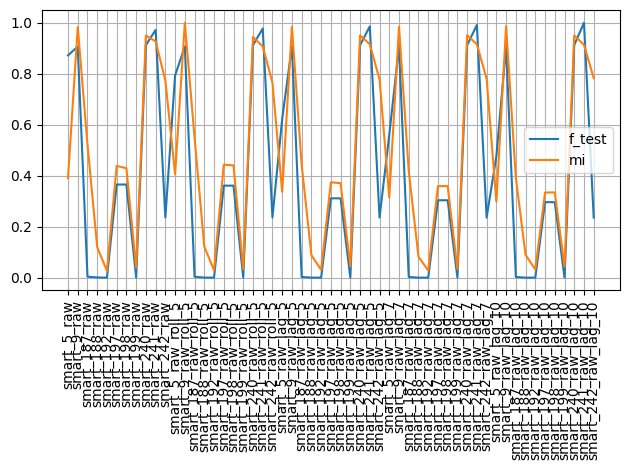

In [ ]:
plt.plot(f_selected, label="f_test")
plt.xticks(ticks=range(len(num_cols)), labels=num_cols, rotation=90)
plt.plot(mi_selected, label="mi")
plt.legend()
plt.grid()
plt.tight_layout()

In [ ]:
stats_feat_sel = np.array(num_cols)[(f_selected > 0.7) | (mi_selected > 0.7)].tolist()
paper_feat_sel = [
    col for name in [
        "smart_5_raw", "smart_187_raw", "smart_188_raw", "smart_197_raw", "smart_198_raw"
       ] for col in num_cols if col.startswith(name)

]

* del smart_198_raw due to the fact that it's strongly correlated with smart_197_raw
and the last one has a bit more dependence to failure

* del smart_240_raw and take smart_9_raw to replace it

<Axes: >

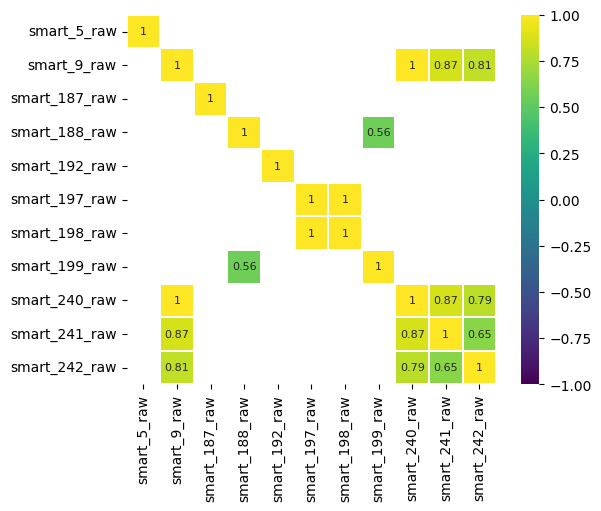

In [ ]:
correlated = x_train[
    [
        'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
        'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
        'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
    ]
].corr()
sns.heatmap(
    correlated[(correlated > 0.5) | (correlated <= -0.5)],
    cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
    annot=True, annot_kws={"size": 8}, square=True
)

In [ ]:
stats_feat_sel = [
    col for col in stats_feat_sel if not col.startswith("smart_240_raw") and \
        not col.startswith("smart_198_raw")
]
paper_feat_sel = [
    col for col in paper_feat_sel if not col.startswith("smart_240_raw") and \
        not col.startswith("smart_198_raw")
]

### Select from model

In [ ]:
logistic_feat_sel = SelectFromModel(LogisticRegression(
    "l1", class_weight="balanced", solver="liblinear", max_iter=1500, C=0.8)
).fit(x_train.loc[:, num_cols], y_train).get_feature_names_out(num_cols)
logistic_feat_sel

c:\Users\Lev\source\ml_project\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array(['smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_192_raw',
       'smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_240_raw',
       'smart_5_raw_roll_5', 'smart_9_raw_roll_5', 'smart_187_raw_roll_5',
       'smart_192_raw_roll_5', 'smart_197_raw_roll_5',
       'smart_198_raw_roll_5', 'smart_199_raw_roll_5',
       'smart_240_raw_roll_5', 'smart_5_raw_lag_5', 'smart_9_raw_lag_5',
       'smart_187_raw_lag_5', 'smart_192_raw_lag_5',
       'smart_197_raw_lag_5', 'smart_198_raw_lag_5',
       'smart_199_raw_lag_5', 'smart_240_raw_lag_5', 'smart_5_raw_lag_7',
       'smart_187_raw_lag_7', 'smart_192_raw_lag_7',
       'smart_197_raw_lag_7', 'smart_198_raw_lag_7',
       'smart_199_raw_lag_7', 'smart_240_raw_lag_7', 'smart_5_raw_lag_10',
       'smart_9_raw_lag_10', 'smart_187_raw_lag_10',
       'smart_192_raw_lag_10', 'smart_197_raw_lag_10',
       'smart_198_raw_lag_10', 'smart_199_raw_lag_10',
       'smart_240_raw_lag_10'], dtype=object)

## Dimensionality reduction

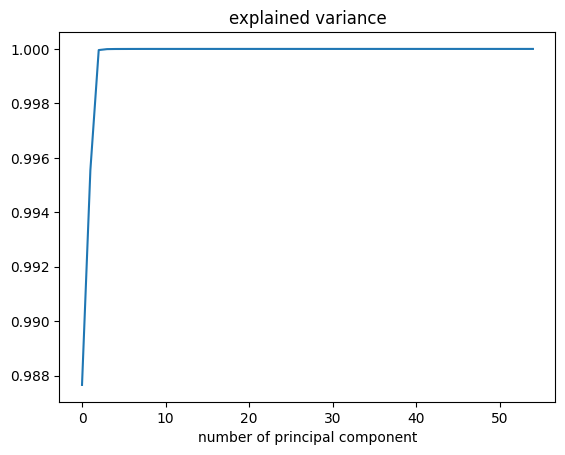

[0.98765971 0.99554331 0.99995792 0.99999252 0.99999722 0.99999817
 0.99999898 0.99999943 0.99999971 0.99999986 0.99999991 0.99999996
 0.99999999 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]


In [ ]:
pca = PCA()
pca.fit(x_train[num_cols])
explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_var)
plt.title("explained variance")
plt.xlabel("number of principal component");
plt.show()
print(explained_var)

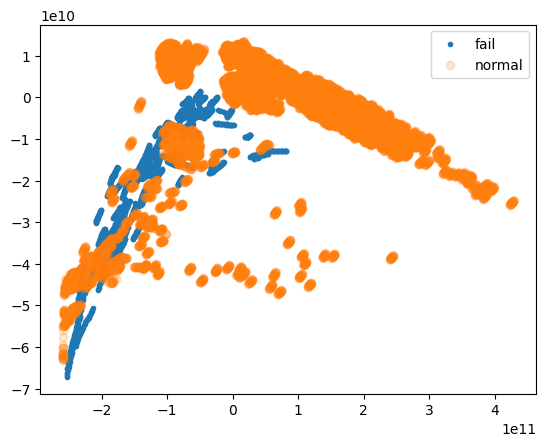

In [ ]:
pca = PCA()
pca.fit(x_train[num_cols])
plt.scatter(
    pca.transform(x_train.loc[y_train == 1, num_cols])[:, 0],
    pca.transform(x_train.loc[y_train == 1, num_cols])[:, 1],
    label="fail", marker="."
);
plt.scatter(
    pca.transform(x_train.loc[y_train == 0, num_cols])[:, 0],
    pca.transform(x_train.loc[y_train == 0, num_cols])[:, 1],
    label="normal", marker="o", alpha=0.2
);
plt.legend()
plt.show()

In [ ]:
rbf = RBFSampler(n_components=30).fit(x_train)
plt.scatter(
    rbf.transform(x_train.loc[y_train == 1, num_cols])[:, 0],
    rbf.transform(x_train.loc[y_train == 1, num_cols])[:, 1],
    label="fail", marker="."
);
plt.scatter(
    rbf.transform(x_train.loc[y_train == 0, num_cols])[:, 0],
    rbf.transform(x_train.loc[y_train == 0, num_cols])[:, 1],
    label="normal", marker="o", alpha=0.2
);
plt.legend()
plt.show()

## Class balancing

In [ ]:
adasyn = ADASYN(n_neighbors=10, random_state=42, sampling_strategy="minority")
x_resampled, y_resampled = adasyn.fit_resample(x_train[num_cols], y_train)
y_resampled.value_counts()

In [ ]:
kmeanssmote = KMeansSMOTE(
    random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
)
x_resampled, y_resampled = kmeanssmote.fit_resample(x_train[num_cols], y_train)
y_resampled.value_counts()

failure
0    266352
1    266352
Name: count, dtype: int64

## Model evaluation

Define to use:
* XGBClassifier
* BalancedRandomForestClassifier
* RandomForestClassifier
* IsolationForest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_last_days = pd.read_csv("/content/drive/MyDrive/last_31_days_lag.csv", parse_dates=["date"])

### XGBClassifier

Preprocessing: ADASYN(n_neighbors=5)

In [ ]:
PreprocessingTest(XGBClassifier, df_last_days)

Balancing class: adasyn
[(0.9368941682577658, 'adasyn'), (0.9219445466347487, 'smote'), (0.6941323311179944, 'kmeanssmote'), (0.8153949601473556, 'default')]
Dimensionality reduction: default
{'pca': 0.7422362195390905, 'rbf': 0.4896541958814185, 'default': 0.8968498874542368}
Feature selection: default
{'stats': 0.7544041135126226, 'paper': 0.7381029037735692, 'lasso': 0.6153157436402868, 'default': 0.8968498874542368}

Prefer dimensionality reduction



In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = TrainValTestSplit(df_last_days)

In [ ]:
estimator = XGBClassifier(eval_metric="auc", early_sopping_rounds=30)

estimator.fit(x_train, y_train)

[07:54:55] ======== Monitor (0): HostSketchContainer ========
[07:54:55] AllReduce: 0.077231s, 1 calls @ 77231us

[07:54:55] MakeCuts: 0.091331s, 1 calls @ 91331us

[07:54:55] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [07:54:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "early_sopping_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


[07:55:07] ======== Monitor (0): Learner ========
[07:55:07] Configure: 0.002095s, 1 calls @ 2095us

[07:55:07] EvalOneIter: 0.001258s, 100 calls @ 1258us

[07:55:07] GetGradient: 0.557448s, 100 calls @ 557448us

[07:55:07] PredictRaw: 0.000343s, 100 calls @ 343us

[07:55:07] UpdateOneIter: 11.1069s, 100 calls @ 11106918us

[07:55:07] ======== Monitor (0): GBTree ========
[07:55:07] BoostNewTrees: 10.5291s, 100 calls @ 10529134us

[07:55:07] CommitModel: 0.000136s, 100 calls @ 136us

[07:55:07] ======== Monitor (0): HistUpdater ========
[07:55:07] BuildHistogram: 4.75082s, 500 calls @ 4750818us

[07:55:07] EvaluateSplits: 0.98115s, 600 calls @ 981150us

[07:55:07] InitData: 0.223528s, 100 calls @ 223528us

[07:55:07] InitRoot: 2.67468s, 100 calls @ 2674676us

[07:55:07] LeafPartition: 3.4e-05s, 100 calls @ 34us

[07:55:07] UpdatePosition: 1.85675s, 600 calls @ 1856753us

[07:55:07] UpdatePredictionCache: 0.136298s, 100 calls @ 136298us

[07:55:07] UpdateTree: 10.3831s, 100 calls @ 1038

XGBoostError: value 10 for Parameter verbosity exceed bound [0,3]
verbosity: Flag to print out detailed breakdown of runtime.

In [ ]:
estimator = XGBClassifier(eval_metric="auc", early_sopping_rounds=30)
adasyn = ADASYN(n_neighbors=5, random_state=42, sampling_strategy="minority")

params = {
    "n_estimators": np.linspace(start=1000, stop=10001, num=20, dtype=int),
    "max_depth": range(3, 16, 2)
}

model = RandomizedSearchCV(estimator, params, n_iter=30, scoring="roc_auc", n_jobs=-1, cv=3)
x_train_res, y_train_res = adasyn.fit_resample(x_train, y_train)
model.fit(x_train_res, y_train_res)

KeyboardInterrupt: 

In [ ]:
print(classification_report(y_val, model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     66588
           1       0.97      0.39      0.56      1060

    accuracy                           0.99     67648
   macro avg       0.98      0.69      0.78     67648
weighted avg       0.99      0.99      0.99     67648



In [ ]:
print(classification_report(y_val, model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     66588
           1       0.92      0.39      0.55      1060

    accuracy                           0.99     67648
   macro avg       0.96      0.69      0.77     67648
weighted avg       0.99      0.99      0.99     67648

